In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

In [2]:
from scipy import sparse as sp

In [3]:
def head_wave_iso(vel, thk, offset, return_all=False):
    m = len(vel)
    vel = np.array(vel, ndmin=1)
    thk = np.array(thk, ndmin=1)
    offset = np.abs(np.array(offset, ndmin=1))
    t = np.zeros((m - 1, len(offset)))
    xnm = np.zeros((m - 1, 1))
    tnm = np.zeros((m - 1, 1))
    t0m = np.zeros((m - 1, 1))
    for i in range(m - 1):
        al = np.arcsin(vel[:(i + 1)] / vel[i + 1])
        _xnm = 2 * np.sum(thk[:(i + 1)] * np.tan(al))
        _tnm = 2 * np.sum(thk[:(i + 1)] / np.cos(al) / vel[:(i + 1)])

        _t0m = 2 * np.sum(thk[:(i + 1)] * np.cos(al) / vel[:(i + 1)])
        t[i] = _t0m + offset / vel[i + 1]
        t[i, offset < _xnm] = np.nan

        xnm[i] = _xnm
        tnm[i] = _tnm
        t0m[i] = _t0m
    if return_all:
        return np.row_stack([offset / vel[0], t]), xnm, tnm, t0m
    return np.nanmin(np.row_stack([offset / vel[0], t]), axis=0)

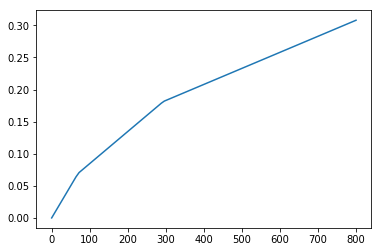

In [56]:
vel = [1000, 2000, 4000]
thk = [20, 80]

ns = 101
nr = 101
rec = np.linspace(0,800, nr)
src = np.linspace(0,800, ns)
offset = cdist(src[..., None], rec[..., None]).ravel()
time = head_wave_iso(vel, thk, offset)

ids = np.arange(ns).repeat(nr)
idr = np.array([np.arange(nr)]*ns).ravel()
ido = np.round(offset/8).astype(int)
no = len(np.unique(ido))

cdp = np.round((rec[idr] - src[ids]) / 2)
time0 = head_wave_iso(vel, thk, rec)
plt.plot(rec, time0)

In [57]:
df = pd.DataFrame(
    np.array([rec[idr], src[ids], offset, time, np.int32(idr), np.int32(ids), np.int32(ido), cdp]).T,
    columns=['GRP', 'SRC', 'OFFSET', 'TIME', 'SN', 'GN', 'ON', 'CDP']
)
df['nCDP'] = np.int32(df.groupby('CDP')['TIME'].transform('count'))
df.head()

,GRP,SRC,OFFSET,TIME,SN,GN,ON,CDP,nCDP
0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,101
1,8.0,0.0,8.0,0.008,1.0,0.0,1.0,4.0,100
2,16.0,0.0,16.0,0.016,2.0,0.0,2.0,8.0,99
3,24.0,0.0,24.0,0.024,3.0,0.0,3.0,12.0,98
4,32.0,0.0,32.0,0.032,4.0,0.0,4.0,16.0,97


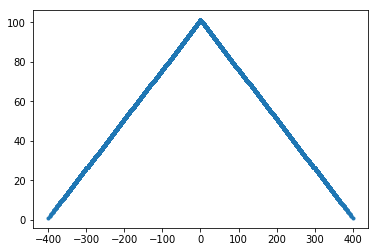

In [59]:
x = df['CDP'].values
y = df['nCDP'].values
plt.plot(x, y, '.')

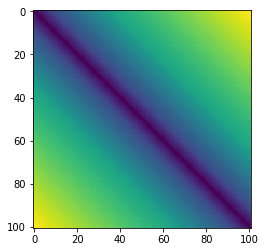

In [69]:
plt.imshow(time.reshape(ns, nr))

In [80]:
ind_fold = df.nCDP[df.nCDP > 10].index.values

In [143]:
def create_operator(cols, fill_data, time):

    col = np.empty(shape=(0,))
    for c in cols:
        col = np.hstack((col, c + len(col)))
#     [    
#         ids[ind_fold], 
#         len(np.unique(ids[ind_fold])) + idr[ind_fold], 
#         len(np.unique(ids[ind_fold])) + len(np.unique(idr[ind_fold])) + idr[ind_fold],
#         len(np.unique(ids[ind_fold])) + 2 * len(np.unique(idr[ind_fold])) + ido[ind_fold]
#     ]
    
    data = np.empty(shape=(0,))
    for d in fill_data:
        data = np.hstack([data, d])
        
#         [
#             np.ones(len(time[ind_fold])),
#             np.ones(len(time[ind_fold])),
#             offset[ind_fold],
#             np.ones(len(time[ind_fold]))
#         ]
    

    row = np.hstack([np.arange(len(time))] * len(col))
    col = np.hstack(col)

    regressor_sp = sp.csc_matrix((data, (row, col)))
    return regressor_sp, time

In [141]:
np.empty(shape=(np.size(time),0)).shape

(10201, 0)

In [142]:
cols = [ids[ind_fold], idr[ind_fold], idr[ind_fold], ido[ind_fold]]
fill_data = [np.ones(len(ind_fold)), np.ones(len(ind_fold)), offset[ind_fold], np.ones(len(ind_fold))]
regressor_sp, time_sp = create_operator(cols, fill_data, time[ind_fold])

30363.0


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [132]:
regressor_sp.shape

(10091, 103)

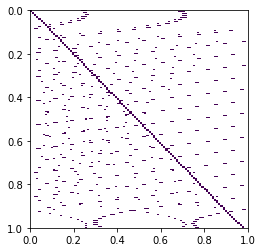

In [131]:
plt.imshow(regressor_sp / regressor_sp, extent=(0,1,1,0))

In [90]:
from scipy.sparse.linalg import inv
from scipy import sparse as sp

In [91]:
theta = sp.linalg.lsqr(regressor_sp.T @ regressor_sp, regressor_sp.T @ time[ind_fold][..., None], show=2, damp=.5)
theta = theta[0]

 
LSQR            Least-squares solution of  Ax = b
The matrix A has      394 rows  and      394 cols
damp = 5.00000000000000e-01   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      788
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.471e+04  5.471e+04    1.0e+00  2.4e+02
     1  7.34361e-07   2.370e+04  2.370e+04    4.3e-01  6.0e-01   1.5e+07  1.0e+00
     2  1.55327e-06   1.249e+04  1.249e+04    2.3e-01  4.7e-01   1.8e+07  2.2e+00
     3  1.96224e-06   6.370e+03  6.370e+03    1.2e-01  4.2e-01   2.1e+07  3.6e+00
     4  2.13962e-06   3.130e+03  3.130e+03    5.7e-02  3.8e-01   2.4e+07  4.9e+00
     5  2.19376e-06   1.514e+03  1.514e+03    2.8e-02  3.4e-01   2.7e+07  6.2e+00
     6  2.21094e-06   7.284e+02  7.284e+02    1.3e-02  3.1e-01   2.9e+07  7.5e+00
     7  2.21553e-06   3.502e+02  3.502e+02    6.4e-03  2.9e-01   3.2e+07  8.8e+00
     8  2.21678e-06   1.700e

   304 -1.83666e-03   9.385e-01  9.455e-01    1.7e-05  1.2e-04   2.0e+08  9.1e+06
   305 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  3.9e-05   2.0e+08  9.1e+06
   306 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  1.6e-05   2.0e+08  9.1e+06
   307 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  4.7e-06   2.0e+08  9.1e+06
   308 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  1.6e-06   2.0e+08  9.1e+06
   309 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  5.6e-07   2.0e+08  9.1e+06
   310 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  3.3e-07   2.0e+08  9.2e+06
   311 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  2.0e-07   2.0e+08  9.2e+06
   312 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  3.2e-07   2.0e+08  9.2e+06
   313 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  2.5e-07   2.0e+08  9.2e+06
   314 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  1.9e-06   2.0e+08  9.2e+06
   315 -1.83663e-03   9.385e-01  9.454e-01    1.7e-05  3.2e-06   2.0e+08  9.2e+06
   316 -1.83663e

In [92]:
time_dec = regressor_sp.dot(theta)

In [ ]:
src_bias = theta[:ns]
rec_bias = theta[ns:(nr+ns)]
rec_vel0 = theta[(nr+ns): (ns + nr*2)]
rec_vel0 = 1 / (rec_vel0 + 1e-16)
off_bias = theta[(2*nr+ns): (ns + nr*2 + no)]

In [ ]:
plt.plot(src_bias)
plt.plot(rec_bias)
plt.plot(rec_bias + src_bias)

In [ ]:
plt.plot(rec_vel0)

In [ ]:
plt.scatter(offset, time, s=1)
plt.scatter(offset, time_dec,s=1)


In [ ]:
plt.plot(rec, off_bias)

In [ ]:
plt.plot(rec, 1/(np.gradient(off_bias)/6 + 1/rec_vel0.max()))

In [ ]:
plt.plot(rec, off_bias)

In [ ]:
regressor_sp = sp.csc_matrix(regressor)
theta_sp = sp.linalg.lsqr(regressor_sp.T @ regressor_sp,regressor_sp.T @ T_ravel,show=2)
theta_sp = theta_sp[0]

In [ ]:
first_break_h = regressor @ theta

In [ ]:
M = 0
offset_i = X[M]

plt.figure(figsize=(10,5))
plt.plot(offset_i, T[M], '-k', lw=3, label='True')
plt.plot(offset_i, first_break_h[ns*M:ns*(M+1)], '--m', lw=3, label='Decomposition')

plt.plot(offset_i, theta[:ns], 'or', ms=2, label='b_source')
plt.plot(offset_i, theta[nr:nr*2].ravel(), '.b', ms=3, label='b_receivers')
# plt.plot(offset_i, theta[4*N*2:4*N*3].ravel() * R[M], '.k', ms=2, label='slowness')
# plt.plot([0, 100, 200, 300], theta[4*N*3:].ravel(), '*g', ms=10, label='b_offset')


plt.legend(loc='best')
plt.show()

In [ ]:
T[0, 17:23]

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(T[0, :])

In [ ]:
plt.plot(1 / theta[-4:])